# Load python packages

In [1]:
# sc
import scdrs
import pegasus as pg
import scanpy as sc
import anndata as ad

# plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

# data
import numpy as np
import pandas as pd
import os
import csv
import glob
import re
import pynndescent
from scipy.stats import zscore
from joblib import dump

/sc/arion/work/yangh17/conda/envs/snRNAseq_py3.9/lib/python3.9/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/sc/arion/work/yangh17/conda/envs/snRNAseq_py3.9/lib/python3.9/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/sc/arion/work/yangh17/conda/envs/snRNAseq_py3.9/lib/python3.9/umap/dist

In [ ]:
print(scdrs)

In [1]:
# snRNAseq_R42 for scdrs plot
import scdrs
import scanpy as sc
import pandas as pd

# Load R libraries

In [ ]:
# monocle3 conda environment
# Load libraries
library(Seurat)
library(Signac)
library(ggplot2)
library(dplyr)
library(zellkonverter)
set.seed(222)
library(RColorBrewer)
library(viridis)
library(monocle3)
library(tidyselect)
library(grid)
library(mgcv)
library(colorspace)
library(ggrepel)
library(igraph)
library(pbapply)
library(devtools)
library(parallel)
library(evobiR)
library(tidyr)
library(cluster)
library(grDevices)
library(repr)
library(zoo)
library(ggnewscale)
library(VennDiagram)
library(ggridges)
library(data.table)
library(splines)
require(speedglm)
library(pheatmap)

## Load python functions

### Initial settings: color, order, traits

In [13]:
from initial_settings import *

## Calculate scDRS

In [4]:
def scDRS_calculate(file_h5ad, file_gs):
    adata = sc.read_h5ad(file_h5ad)

    scdrs.preprocess(adata, n_mean_bin=20, n_var_bin=20, copy=False)

    dict_gs = scdrs.util.load_gs(file_gs,
                            src_species="human",dst_species="human",to_intersect=adata.var_names)


    dict_df_score = dict()
    for trait in dict_gs:
        gene_list, gene_weights = dict_gs[trait]
        dict_df_score[trait] = scdrs.score_cell(
            data=adata,
            gene_list=gene_list,
            gene_weight=gene_weights,
            ctrl_match_key="mean_var",
            n_ctrl=80,
            weight_opt="vs",
            return_ctrl_raw_score=False,
            return_ctrl_norm_score=True,
            verbose=False,
        )
    return(dict_df_score)

# Load R functions

## Plot settings

In [2]:
options(repr.plot.width = 8, repr.plot.height = 5)

## Initial settings: color, trait

In [2]:
source("initial_settings.r")

## Load trajectory reconstruction and downstream analysis based on Kriegstein scripts

In [4]:
source("0_trajectory_reconstruction_based_on_kriestein.r")

## Compress scDRS at meta-cell level

In [5]:
compress_scdrs_traits <- function(cds, traits, start, cell_type, window = F, N = 500, cores = F){
    # Func: compress the scDRS for lineages of cds object
    cds_name <- deparse(substitute(cds))
    if(cores != F){
        cl <- makeCluster(cores)
        clusterEvalQ(cl, c(library(evobiR)))
    }

    # step0. Initialize
    scdrs_list <- list()
    for(sub_trait in traits){
        scdrs_list[[sub_trait]] <- data.frame(matrix(nrow = N, ncol = 0)) # column: lineage 1, 2, ...
    }
    
    for(sub_lin in names(cds@lineages)){
        # step1. Obtain object for specific lineage
        input <- paste0("get_lineage_object(",cds_name,", lineage = '", sub_lin, "', start = ", start, ")")
        cds_subset <- eval(parse(text=input))
        cells <- colnames(cds_subset)
    
        
        window <- ncol(cds_subset)/N
        step <- (ncol(cds_subset)-window)/N

        print(sub_lin)
        print(paste0("Window: ", window))
        print(paste0("Step: ", step))
        
   
        # step2. Extract the pseudotime information
        pt <- cds_subset@principal_graph_aux@listData[["UMAP"]][["pseudotime"]]
        pt <- pt[order(pt)]

        for(sub_trait in traits){
            # step3. Prepare for scDRS information
            scdrs <- as.data.frame(fread(paste0("files/freeze3/scDRS/All_26_consistent_traits_not_removing_covariate/scDRS_from_python_", sub_trait, ".csv")))
            rownames(scdrs) <- scdrs[[1]]
            scdrs <- scdrs[-1]
            scdrs <- scdrs[names(pt), "zscore"]
            
            # step4. Compress using sliding window
            scdrs.comp <- SlidingWindow("mean", scdrs, window, step)
            scdrs_list[[sub_trait]] <- cbind(scdrs_list[[sub_trait]], t(data.frame(matrix(scdrs.comp, nrow = 1, ncol = N), row.names = sub_lin)))
        }
    }
    saveRDS(scdrs_list, file = paste0("files/freeze3/scDRS/All_26_consistent_traits_not_removing_covariate/scDRS_zscore_from_python_", cell_type,".RDS"))
    return(scdrs_list)
}

## Obtain fitted scDRS for each cell type

In [9]:
obtain_fitted_scdrs <- function(cds, file_scdrs, model = "scdrs ~ ns(pseudotime, df=3)"){
    scdrs_list <- readRDS(file_scdrs)
    
    # step0. Initialize
    scdrs_fitted_list <- scdrs_list

    for(sub_trait in names(scdrs_list)){
        for(sub_lin in colnames(scdrs_list[[sub_trait]])){
            pt <- as.numeric(unlist(cds@pseudotime[[sub_lin]]))
            score <- scdrs_list[[sub_trait]][[sub_lin]]
            df_sel <- data.frame(pseudotime = pt, scdrs = score)
            d <- data.frame(pseudotime = seq(from = 0, to = max(pt), by = max(pt)/(length(pt) - 1)))

            fit <- speedglm(model, data = df_sel, acc = 1e-3, model = F, y = F)
            fitted <- as.numeric(stats::predict(fit, newdata = d, type = "response"))
            scdrs_fitted_list[[sub_trait]][[sub_lin]] <- fitted
        }
    }
    return(scdrs_fitted_list)
}

### Fitted scDRS

In [6]:
# Source: https://gist.github.com/mathzero/a2070a24a6b418740c44a5c023f5c01e
save_pheatmap <- function(x, filename, width=12, height=12){
    stopifnot(!missing(x))
    stopifnot(!missing(filename))
    if(grepl(".png",filename)){
        png(filename, width=width, height=height, units = "in", res=300)
        grid::grid.newpage()
        grid::grid.draw(x$gtable)
        dev.off()
    }
    else if(grepl(".pdf",filename)){
        pdf(filename, width=width, height=height)
        grid::grid.newpage()
        grid::grid.draw(x$gtable)
        dev.off()
    }
    else{
      print("Filename did not contain '.png' or '.pdf'")
    }
}

plot_heatmap_fitted_scdrs <- function(scdrs_list, lineages, branches, n_metacell, out_file, figure_width = 8, figure_height = 5, vmin = -1, vmax = 1, border_color = NA){
    df_scdrs <- data.frame(matrix(ncol=length(lineages)*n_metacell, nrow = 0))
    for(sub_trait in names(trait_info)){
        if(length(lineages) == 2){
            df_sub_trait <- data.frame(matrix(c(rev(scdrs_list[[sub_trait]][[1]]), scdrs_list[[sub_trait]][[2]]), nrow = 1))
        }else{
            df_sub_trait <- data.frame(matrix(as.numeric(unlist(scdrs_list[[sub_trait]])), nrow = 1))
        }
        rownames(df_sub_trait) <- trait_info[sub_trait]
        df_scdrs <- rbind(df_scdrs, df_sub_trait)
    }


    # Annotation for columns
    annotation_col = data.frame(
                                CellType = factor(rep(lineages, each = n_metacell)), 
                                Branch = factor(branches))
    rownames(annotation_col) = colnames(df_scdrs)
    ann_colors <- list(CellType = cols_subclass_uni[lineages], Branch = cols_subclass_uni[unique(branches)])


    ph <- pheatmap(df_scdrs, 
                   cluster_rows = F, 
                   cluster_cols = F, 
                   scale = "none", 
                   show_rownames = T, 
                   show_colnames = F, 
                   annotation_col = annotation_col,
                   annotation_colors = ann_colors,
                   breaks = seq(vmin, vmax, length.out = 100),
                   # color = color_scale_heatmap, 
                   color = colorRampPalette(c("#2C7BB6", "white", "#D7191C"))(100),
                   border_color = border_color)
    save_pheatmap(ph, out_file, width=figure_width, height=figure_height)
}

## Calculate scDRS

In [ ]:
dict_df_score = scDRS_calculate(file_h5ad = '/sc/arion/projects/CommonMind/aging/hui/files/freeze3/aging_lister_integrated_ds1000_rmno_scanpy6000_half_100_123456_UMAT_adata.h5ad', 
                file_gs = '/sc/arion/projects/CommonMind/aging/hui/files/freeze3/scDRS/all_ms_geneset_newOrd_agingsubset.gs')

In [9]:
dump(dict_df_score, '/sc/arion/projects/CommonMind/aging/hui/files/freeze3/scDRS/All_26_consistent_traits_not_removing_covariate/scDRS_from_python.joblib', compress=3)

26

### Export each trait to csv file for R reading

In [ ]:
for key, value in dict_df_score.items():
    if isinstance(value, pd.DataFrame):
        value.to_csv(f'files/freeze3/scDRS/All_26_consistent_traits_not_removing_covariate/scDRS_from_python_{key}.csv')

# Compressed scDRS

## Astrocyte

### Load data

In [7]:
cds_AST <- readRDS("/sc/arion/projects/CommonMind/aging/hui/files/freeze3/aging_lister_integrated_ds1000_rmno_scanpy6000_half_100_123456_beforeUMAT_AST_scanpy6000_25_sparse_123456_afterCombination_cds_compressed.RDS")
cds_AST

class: cell_data_set_ext 
dim: 14613 173241 
metadata(0):
assays(2): counts logcounts
rownames(14613): DPM1 SCYL3 ... OOSP1 C8orf44-SGK3
rowData names(2): gene_name gene_short_name
colnames(173241): H1007-1-AACACACAGTAATTGG-0-Aging
  H1007-1-AACTTCTCATCTCGTC-0-Aging ...
  TTTGTTGAGCGATTCT-RL2132_25yr_v3-Lister
  TTTGTTGCACAAGCTT-RL2132_25yr_v3-Lister
colData names(55): orig.ident nCount_RNA ... ident Size_Factor
reducedDimNames(1): UMAP
mainExpName: RNA
altExpNames(0):

In [6]:
names(cds_AST@lineages)

[1] "Astro_PLSCR1"   "Astro_ADAMTSL3"

### All traits

In [ ]:
scdrs_AST <- compress_scdrs_traits(cds_AST, names(trait_info), 863, cell_type = "AST", window = F, N = 500, cores = 20)


In [39]:
for(sub_trait in c("migraines_2021", "eduAttainment", "ms", "dm2")){
    # Plot regressed lines
    trait_res_ggplot <- data.frame(Pseudotime = c(), scDRS = c(), Lineage = c())
    for(sub_lin in names(cds_AST@lineages)){
        trait_res_ggplot <- rbind(trait_res_ggplot, data.frame(Pseudotime = as.numeric(unlist(cds_AST@pseudotime[[sub_lin]])), 
                                                               scDRS = scdrs_AST[[sub_trait]][[sub_lin]], 
                                                               Lineage = rep(sub_lin, 500)))
    }
    p <- ggplot(trait_res_ggplot, aes(x=Pseudotime, y=scDRS, color=Lineage)) + 
        scale_color_manual(values = cols_subclass_uni) +
        geom_smooth(method = "lm", formula = y ~ ns(x, df = 3), se = TRUE) +
        geom_hline(yintercept = 0, linetype = "44", color = "black", size = 1) +
        scale_y_continuous(limits = c(-0.2, 1)) +
        labs(title = trait_info[sub_trait]) +
        theme(plot.title = element_text(size = 14, face = "bold", hjust = 0.5)) +
        theme_classic()
    pdf(paste0("/sc/arion/projects/CommonMind/aging/hui//files/freeze3/figures/ast_scdrs_zscore_trendline_", sub_trait, ".pdf"), width = 5, height = 5)
        print(p)
    dev.off()
}

Warning message:
“Removed 1 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 57 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 4 rows containing non-finite values (`stat_smooth()`).”


#### Heatmap (Fitted)

png 
  2

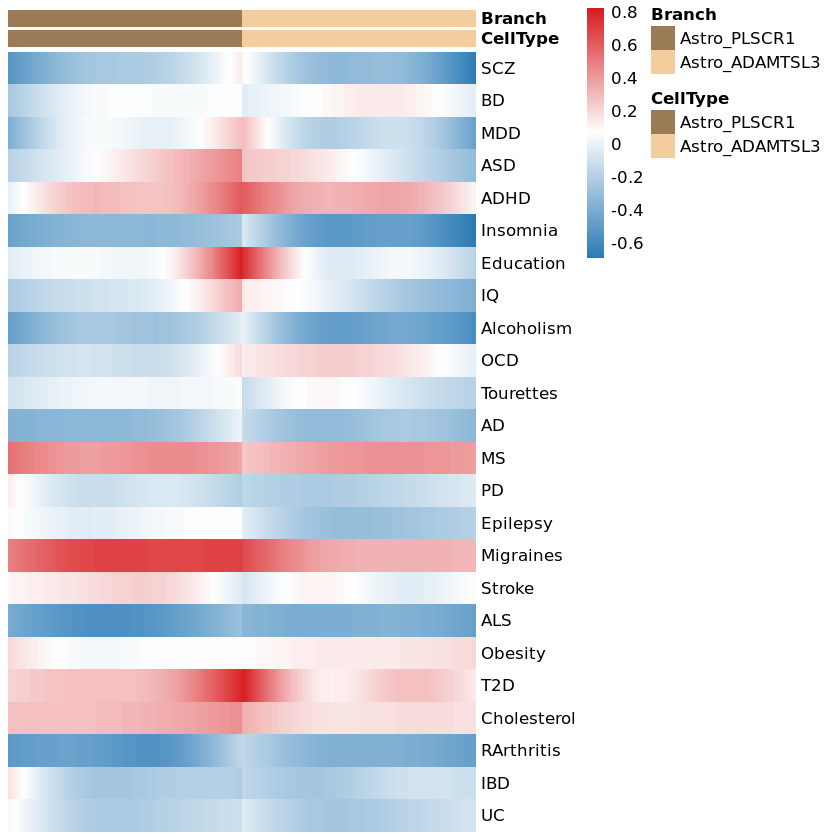

In [10]:
scdrs_fitted_AST <- obtain_fitted_scdrs(cds_AST, "/sc/arion/projects/CommonMind/aging/hui/files/freeze3/scDRS/All_26_consistent_traits_not_removing_covariate/scDRS_zscore_from_python_AST.RDS")
plot_heatmap_fitted_scdrs(scdrs_fitted_AST, 
                          lineages = names(cds_AST@lineages), 
                          branches = rep(c("Astro_PLSCR1", "Astro_ADAMTSL3"), each = 500), 
                          n_metacell = 500, 
                          out_file = "/sc/arion//projects/CommonMind/aging/hui/files//freeze3/figures/ast_scdrs_zscore_heatmap.pdf",
                          figure_width = 8,
                          figure_height = 5,
                          vmin = min(unlist(scdrs_fitted_AST)), 
                          vmax = max(unlist(scdrs_fitted_AST)))


## Excitatory neuron

### Load data

In [8]:
cds_EN <- readRDS("/sc/arion/projects/CommonMind/aging/hui/files/freeze3/aging_lister_integrated_ds1000_rmno_scanpy6000_half_100_123456_beforeUMAT_EN_scanpy6000_25_sparse_123456_afterCombination_cds_compressed.RDS")
cds_EN

class: cell_data_set_ext 
dim: 14649 349350 
metadata(0):
assays(2): counts logcounts
rownames(14649): DPM1 SCYL3 ... OOSP1 C8orf44-SGK3
rowData names(2): gene_name gene_short_name
colnames(349350): H1007-1-AAACGAAAGTTGTAGA-0-Aging
  H1007-1-AAACGCTAGGAACGTC-0-Aging ...
  TTTGTTGCAACAGTGG-RL2132_25yr_v3-Lister
  TTTGTTGGTTCGGCTG-RL2132_25yr_v3-Lister
colData names(55): orig.ident nCount_RNA ... ident Size_Factor
reducedDimNames(1): UMAP
mainExpName: RNA
altExpNames(0):

In [7]:
names(cds_EN@lineages)

[1] "EN_L6B"       "EN_L6_CT"     "EN_L5_6_NP"   "EN_L6_IT_1"   "EN_L6_IT_2"  
[6] "EN_L3_5_IT_1" "EN_L3_5_IT_2" "EN_L3_5_IT_3" "EN_L2_3_IT"

### All traits

In [ ]:
scdrs_EN <- compress_scdrs_traits(cds_EN, names(trait_info), 3186, cell_type = "EN", window = F, N = 500, cores = 20)
for(sub_trait in names(scdrs_EN)){
    # Plot regressed lines
    trait_res_ggplot <- data.frame(xValue = c(), yValue = c(), group = c())
    for(sub_lin in names(cds_EN@lineages)){
        trait_res_ggplot <- rbind(trait_res_ggplot, data.frame(xValue = as.numeric(unlist(cds_EN@pseudotime[[sub_lin]])), 
                                                               yValue = scdrs_EN[[sub_trait]][[sub_lin]], 
                                                               group = rep(sub_lin, 500)))
    }
    p <- ggplot(trait_res_ggplot, aes(x=xValue, y=yValue, color=group)) + 
        scale_color_manual(values = cols_subclass_uni) +
        geom_smooth(method = "lm", formula = y ~ ns(x, df = 3), se = TRUE) +
        geom_hline(yintercept = 0, linetype = "44", color = "black", size = 1) +
        scale_y_continuous(limits = c(-1, 1)) +
        labs(title = paste("EN", trait_info[sub_trait], sep = "_")) +
        theme(plot.title = element_text(size = 14, face = "bold", hjust = 0.5))
        theme_classic()
    print(p)
}

In [ ]:
for(sub_trait in c("sz3", "bip2", "mdd_ipsych", "asd", "adhd_ipsych", "insomn2", "eduAttainment", "intel", "alcohilism_2019", "tourette", "obesity", "dm2")){
    # Plot regressed lines
    trait_res_ggplot <- data.frame(Pseudotime = c(), scDRS = c(), Lineage = c())
    for(sub_lin in names(cds_EN@lineages)){
        trait_res_ggplot <- rbind(trait_res_ggplot, data.frame(Pseudotime = as.numeric(unlist(cds_EN@pseudotime[[sub_lin]])), 
                                                               scDRS = scdrs_EN[[sub_trait]][[sub_lin]], 
                                                               Lineage = rep(sub_lin, 500)))
    }
    p <- ggplot(trait_res_ggplot, aes(x=Pseudotime, y=scDRS, color=Lineage)) + 
        scale_color_manual(values = cols_subclass_uni) +
        geom_smooth(method = "lm", formula = y ~ ns(x, df = 3), se = TRUE) +
        geom_hline(yintercept = 0, linetype = "44", color = "black", size = 1) +
        scale_y_continuous(limits = c(-0.5, 1.5)) +
        labs(title = trait_info[sub_trait]) +
        theme(plot.title = element_text(size = 14, face = "bold", hjust = 0.5)) +
        theme_classic()
    pdf(paste0("/sc/arion/projects/CommonMind/aging/hui//files/freeze3/figures/en_scdrs_zscore_trendline_", sub_trait, ".pdf"), width = 5, height = 5)
        print(p)
    dev.off()
}

#### Heatmap (Fitted)

png 
  2

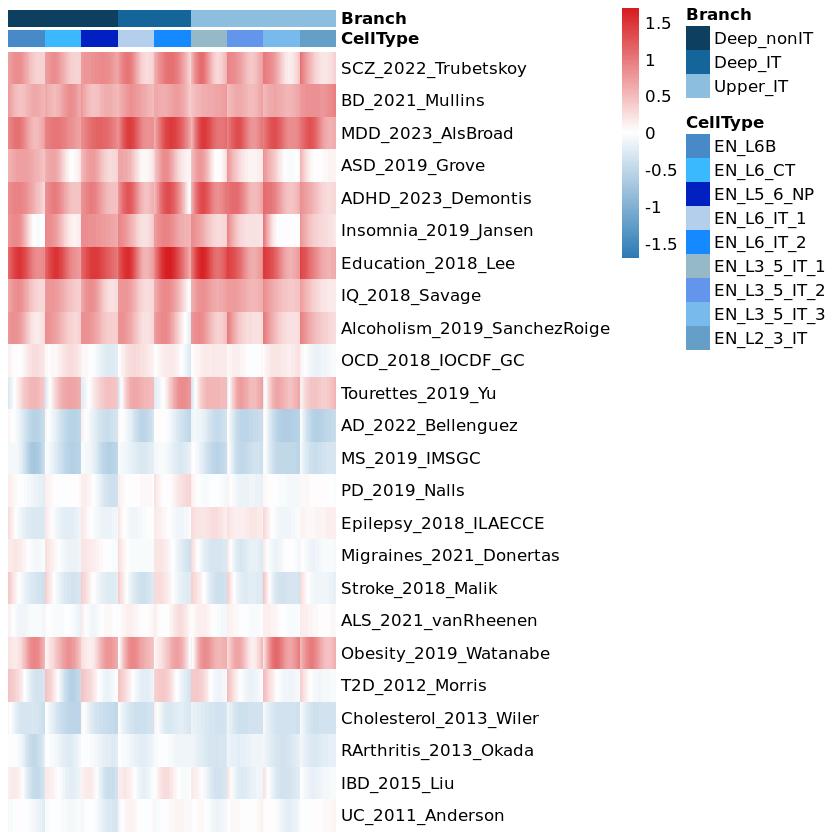

In [14]:
scdrs_fitted_EN <- obtain_fitted_scdrs(cds_EN, "/sc/arion/projects/CommonMind/aging/hui/files/freeze3/scDRS/All_26_consistent_traits_not_removing_covariate/scDRS_zscore_from_python_EN.RDS")
plot_heatmap_fitted_scdrs(scdrs_fitted_EN, 
                          lineages = names(cds_EN@lineages), 
                          branches = c(rep("Deep_nonIT", 1500), rep("Deep_IT", 1000), rep("Upper_IT", 2000)),
                          n_metacell = 500, 
                          out_file = "/sc/arion//projects/CommonMind/aging/hui/files//freeze3/figures/en_scdrs_zscore_heatmap.pdf",
                          figure_width = 5,
                          figure_height = 5,
                          vmin = -max(abs(unlist(scdrs_fitted_EN))), 
                          vmax = max(abs(unlist(scdrs_fitted_EN))))


## Inhibitory neuron

### Load data

In [10]:
cds_IN <- readRDS("/sc/arion/projects/CommonMind/aging/hui/files/freeze3/aging_lister_integrated_ds1000_rmno_scanpy6000_half_100_123456_beforeUMAT_IN_scanpy6000_25_sparse_123456_afterCombination_cds_compressed.RDS")
cds_IN

class: cell_data_set_ext 
dim: 14645 254695 
metadata(0):
assays(2): counts logcounts
rownames(14645): DPM1 SCYL3 ... OOSP1 C8orf44-SGK3
rowData names(2): gene_name gene_short_name
colnames(254695): H1007-1-AAAGGATAGAAATGGG-0-Aging
  H1007-1-AAAGGTACATTGCTTT-0-Aging ...
  TTTGTTGCACCGCTGA-RL2132_25yr_v3-Lister
  TTTGTTGTCGTCCTCA-RL2132_25yr_v3-Lister
colData names(55): orig.ident nCount_RNA ... ident Size_Factor
reducedDimNames(1): UMAP
mainExpName: RNA
altExpNames(0):

### All traits

In [ ]:
scdrs_IN <- compress_scdrs_traits(cds_IN, names(trait_info), 4399, cell_type = "IN", window = F, N = 500, cores = 20)
for(sub_trait in names(scdrs_IN)){
    # Plot regressed lines
    trait_res_ggplot <- data.frame(xValue = c(), yValue = c(), group = c())
    for(sub_lin in names(cds_IN@lineages)){
        trait_res_ggplot <- rbind(trait_res_ggplot, data.frame(xValue = as.numeric(unlist(cds_IN@pseudotime[[sub_lin]])), 
                                                               yValue = scdrs_IN[[sub_trait]][[sub_lin]], 
                                                               group = rep(sub_lin, 500)))
    }
    p <- ggplot(trait_res_ggplot, aes(x=xValue, y=yValue, color=group)) + 
        scale_color_manual(values = cols_subclass_uni) +
        geom_smooth(method = "lm", formula = y ~ ns(x, df = 3), se = TRUE) +
        geom_hline(yintercept = 0, linetype = "44", color = "black", size = 1) +
        scale_y_continuous(limits = c(-1, 1)) +
        labs(title = paste("IN", trait_info[sub_trait], sep = "_")) +
        theme(plot.title = element_text(size = 14, face = "bold", hjust = 0.5))
        theme_classic()
    print(p)
}

In [ ]:
for(sub_trait in c("sz3", "bip2", "mdd_ipsych", "asd", "adhd_ipsych", "insomn2", "eduAttainment", "intel", "alcohilism_2019", "ocd", "tourette", "obesity", "dm2")){
    # Plot regressed lines
    trait_res_ggplot <- data.frame(Pseudotime = c(), scDRS = c(), Lineage = c())
    for(sub_lin in names(cds_IN@lineages)){
        trait_res_ggplot <- rbind(trait_res_ggplot, data.frame(Pseudotime = as.numeric(unlist(cds_IN@pseudotime[[sub_lin]])), 
                                                               scDRS = scdrs_IN[[sub_trait]][[sub_lin]], 
                                                               Lineage = rep(sub_lin, 500)))
    }
    p <- ggplot(trait_res_ggplot, aes(x=Pseudotime, y=scDRS, color=Lineage)) + 
        scale_color_manual(values = cols_subclass_uni) +
        geom_smooth(method = "lm", formula = y ~ ns(x, df = 3), se = TRUE) +
        geom_hline(yintercept = 0, linetype = "44", color = "black", size = 1) +
        scale_y_continuous(limits = c(-0.5, 1.5)) +
        labs(title = trait_info[sub_trait]) +
        theme(plot.title = element_text(size = 14, face = "bold", hjust = 0.5)) +
        theme_classic()
    pdf(paste0("/sc/arion/projects/CommonMind/aging/hui//files/freeze3/figures/in_scdrs_zscore_trendline_", sub_trait, ".pdf"), width = 5, height = 5)
        print(p)
    dev.off()
}

#### Heatmap (Fitted)

png 
  2

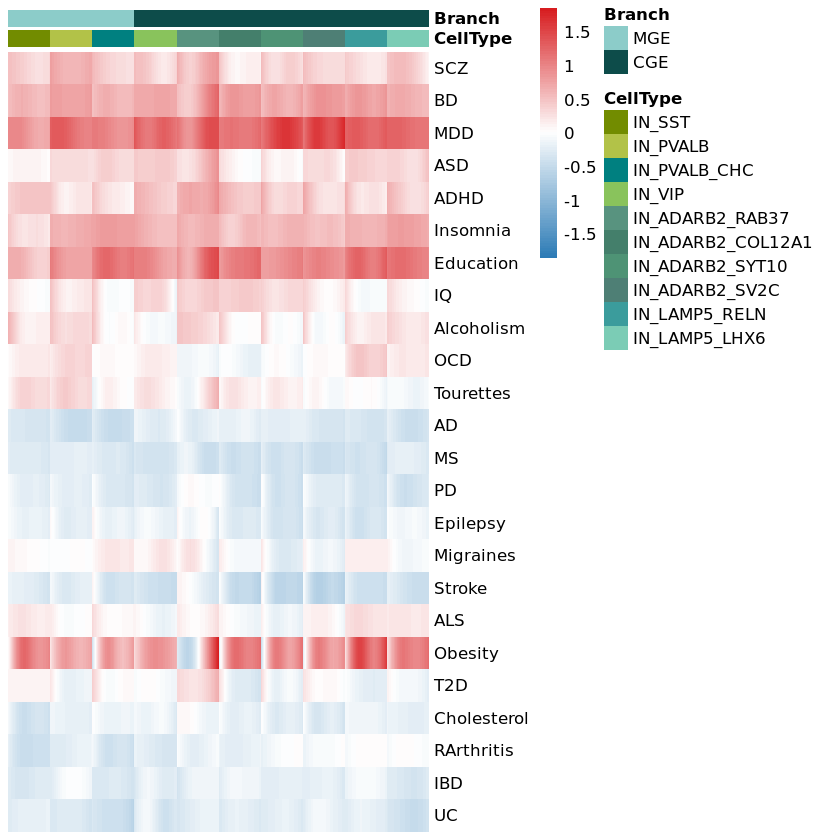

In [11]:
scdrs_fitted_IN <- obtain_fitted_scdrs(cds_IN, "/sc/arion/projects/CommonMind/aging/hui/files/freeze3/scDRS/All_26_consistent_traits_not_removing_covariate/scDRS_zscore_from_python_IN.RDS")
plot_heatmap_fitted_scdrs(scdrs_fitted_IN, 
                          lineages = names(cds_IN@lineages), 
                          branches = c(rep("MGE", 1500), rep("CGE", 3500)), 
                          n_metacell = 500, 
                          out_file = "/sc/arion//projects/CommonMind/aging/hui/files//freeze3/figures/in_scdrs_zscore_heatmap.pdf",
                          figure_width = 5,
                          figure_height = 5,
                          vmin = -max(abs(unlist(scdrs_fitted_IN))), 
                          vmax = max(abs(unlist(scdrs_fitted_IN))))


## Microglia

### Load data

In [18]:
cds_MICRO <- readRDS("/sc/arion/projects/CommonMind/aging/hui/files/freeze3/aging_lister_integrated_ds1000_rmno_scanpy6000_half_100_123456_beforeUMAT_MICRO_scanpy6000_25_sparse_123456_afterCombination_cds_compressed.RDS")
cds_MICRO

class: cell_data_set_ext 
dim: 14479 69463 
metadata(0):
assays(2): counts logcounts
rownames(14479): DPM1 SCYL3 ... TBCE C8orf44-SGK3
rowData names(2): gene_name gene_short_name
colnames(69463): H1007-1-ACCTGTCCATACATCG-0-Aging
  H1007-1-AGACAAAAGACGCAGT-0-Aging ...
  TTTCATGAGAATCGAT-RL2132_25yr_v3-Lister
  TTTGATCTCACTTCTA-RL2132_25yr_v3-Lister
colData names(55): orig.ident nCount_RNA ... ident Size_Factor
reducedDimNames(1): UMAP
mainExpName: RNA
altExpNames(0):

### All traits

In [ ]:
scdrs_MICRO <- compress_scdrs_traits(cds_MICRO, names(trait_info), 38, cell_type = "MICRO", window = F, N = 500, cores = 20)
for(sub_trait in names(trait_info)){
    # Plot regressed lines
    trait_res_ggplot <- data.frame(xValue = c(), yValue = c(), group = c())
    for(sub_lin in names(cds_MICRO@lineages)){
        trait_res_ggplot <- rbind(trait_res_ggplot, data.frame(xValue = as.numeric(unlist(cds_MICRO@pseudotime[[sub_lin]])), 
                                                               yValue = scdrs_MICRO[[sub_trait]][[sub_lin]], 
                                                               group = rep(sub_lin, 500)))
    }
    p <- ggplot(trait_res_ggplot, aes(x=xValue, y=yValue, color=group)) + 
        scale_color_manual(values = cols_subclass_uni) +
        geom_smooth(method = "lm", formula = y ~ ns(x, df = 3), se = TRUE) +
        geom_hline(yintercept = 0, linetype = "44", color = "black", size = 1) +
        scale_y_continuous(limits = c(-1, 1)) +
        labs(title = paste("MICRO", trait_info[sub_trait], sep = "_")) +
        theme(plot.title = element_text(size = 14, face = "bold", hjust = 0.5))
        theme_classic()
    print(p)
}



In [22]:
for(sub_trait in c("alzBellenguezNoApoe", "ms", "ra", "ibd", "uc")){
    # Plot regressed lines
    trait_res_ggplot <- data.frame(Pseudotime = c(), scDRS = c(), Lineage = c())
    for(sub_lin in names(cds_MICRO@lineages)){
        trait_res_ggplot <- rbind(trait_res_ggplot, data.frame(Pseudotime = as.numeric(unlist(cds_MICRO@pseudotime[[sub_lin]])), 
                                                               scDRS = scdrs_MICRO[[sub_trait]][[sub_lin]], 
                                                               Lineage = rep(sub_lin, 500)))
    }
    p <- ggplot(trait_res_ggplot, aes(x=Pseudotime, y=scDRS, color=Lineage)) + 
        scale_color_manual(values = cols_subclass_uni) +
        geom_smooth(method = "lm", formula = y ~ ns(x, df = 3), se = TRUE) +
        geom_hline(yintercept = 0, linetype = "44", color = "black", size = 1) +
        scale_y_continuous(limits = c(-0.2, 2)) +
        labs(title = trait_info[sub_trait]) +
        theme(plot.title = element_text(size = 14, face = "bold", hjust = 0.5)) +
        theme_classic()
    pdf(paste0("/sc/arion/projects/CommonMind/aging/hui//files/freeze3/figures/micro_scdrs_zscore_trendline_", sub_trait, ".pdf"), width = 5, height = 5)
        print(p)
    dev.off()
}

Warning message:
“Removed 58 rows containing non-finite values (`stat_smooth()`).”


#### Heatmap (Fitted)

png 
  2

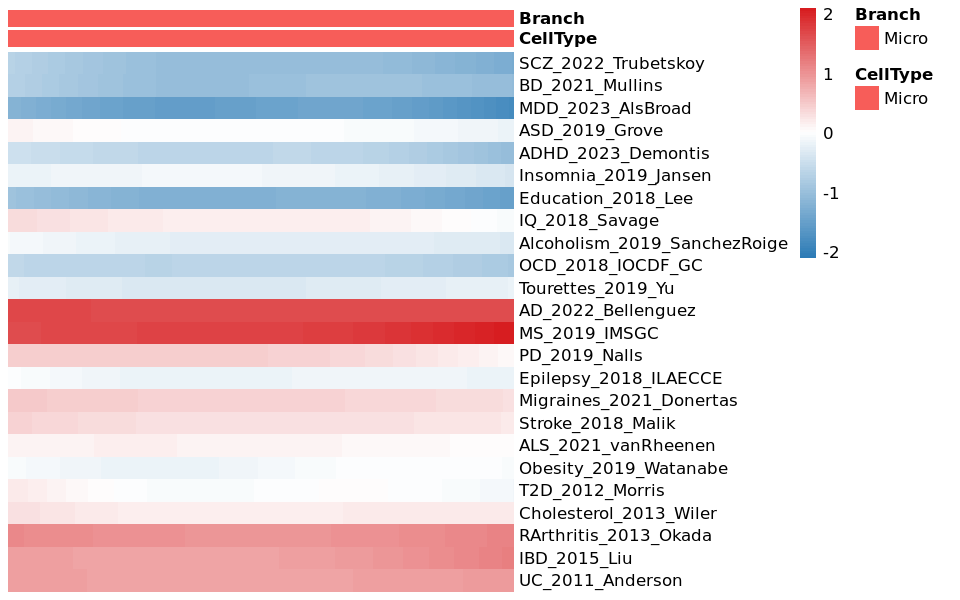

In [26]:
scdrs_fitted_MICRO <- obtain_fitted_scdrs(cds_MICRO, "/sc/arion/projects/CommonMind/aging/hui/files/freeze3/scDRS/All_26_consistent_traits_not_removing_covariate/scDRS_zscore_from_python_MICRO.RDS")
plot_heatmap_fitted_scdrs(scdrs_fitted_MICRO, 
                          lineages = names(cds_MICRO@lineages), 
                          branches = rep("Micro", 500), 
                          n_metacell = 500, 
                          out_file = "/sc/arion//projects/CommonMind/aging/hui/files//freeze3/figures/micro_scdrs_zscore_heatmap.pdf",
                          figure_width = 5,
                          figure_height = 5,
                          vmin = -max(abs(unlist(scdrs_fitted_MICRO))), 
                          vmax = max(abs(unlist(scdrs_fitted_MICRO))))


## Oligodendrocyte

### Load data

In [8]:
cds_OLIGO <- readRDS("/sc/arion/projects/CommonMind/aging/hui/files/freeze3/aging_lister_integrated_ds1000_rmno_scanpy6000_half_100_123456_beforeUMAT_OLIGO_scanpy6000_25_sparse_123456_afterCombination_cds_compressed.RDS")
cds_OLIGO

class: cell_data_set_ext 
dim: 14666 553620 
metadata(0):
assays(2): counts logcounts
rownames(14666): DPM1 SCYL3 ... OOSP1 C8orf44-SGK3
rowData names(2): gene_name gene_short_name
colnames(553620): H1007-1-AAACGAAGTCTCAGGC-0-Aging
  H1007-1-AAACGAATCCCATAGA-0-Aging ...
  TTTGGAGAGTGGAATT-RL2132_25yr_v3-Lister
  TTTGTTGGTAAGGTCG-RL2132_25yr_v3-Lister
colData names(55): orig.ident nCount_RNA ... ident Size_Factor
reducedDimNames(1): UMAP
mainExpName: RNA
altExpNames(0):

### All traits

In [ ]:
scdrs_OLIGO <- compress_scdrs_traits(cds_OLIGO, names(trait_info), 1297, cell_type = "OLIGO", window = F, N = 500, cores = 20)

for(sub_trait in names(scdrs_OLIGO)){
    # Plot regressed lines
    trait_res_ggplot <- data.frame(xValue = c(), yValue = c(), group = c())
    for(sub_lin in names(cds_OLIGO@lineages)){
        trait_res_ggplot <- rbind(trait_res_ggplot, data.frame(xValue = as.numeric(unlist(cds_OLIGO@pseudotime[[sub_lin]])), 
                                                               yValue = scdrs_OLIGO[[sub_trait]][[sub_lin]], 
                                                               group = rep(sub_lin, 500)))
    }
    p <- ggplot(trait_res_ggplot, aes(x=xValue, y=yValue, color=group)) + 
        scale_color_manual(values = cols_subclass_uni) +
        geom_smooth(method = "lm", formula = y ~ ns(x, df = 3), se = TRUE) +
        geom_hline(yintercept = 0, linetype = "44", color = "black", size = 1) +
        scale_y_continuous(limits = c(min(unlist(scdrs_OLIGO)), max(unlist(scdrs_OLIGO)))) +
        labs(title = paste("OLIGO", trait_info[sub_trait], sep = "_")) +
        theme(plot.title = element_text(size = 14, face = "bold", hjust = 0.5))
        theme_classic()
    print(p)
}

In [11]:
for(sub_trait in c("mdd_ipsych", "asd", "adhd_ipsych", "insomn2", "eduAttainment", "alzBellenguezNoApoe", "migraines_2021", "obesity")){
    # Plot regressed lines
    trait_res_ggplot <- data.frame(Pseudotime = c(), scDRS = c(), Lineage = c())
    for(sub_lin in names(cds_OLIGO@lineages)){
        trait_res_ggplot <- rbind(trait_res_ggplot, data.frame(Pseudotime = as.numeric(unlist(cds_OLIGO@pseudotime[[sub_lin]])), 
                                                               scDRS = scdrs_OLIGO[[sub_trait]][[sub_lin]], 
                                                               Lineage = rep(sub_lin, 500)))
    }
    p <- ggplot(trait_res_ggplot, aes(x=Pseudotime, y=scDRS, color=Lineage)) + 
        scale_color_manual(values = cols_subclass_uni) +
        geom_smooth(method = "lm", formula = y ~ ns(x, df = 3), se = TRUE) +
        geom_hline(yintercept = 0, linetype = "44", color = "black", size = 1) +
        scale_y_continuous(limits = c(-2, 2)) +
        labs(title = trait_info[sub_trait]) +
        theme(plot.title = element_text(size = 14, face = "bold", hjust = 0.5)) +
        theme_classic()
    pdf(paste0("/sc/arion/projects/CommonMind/aging/hui//files/freeze3/figures/oligo_scdrs_zscore_trendline_", sub_trait, ".pdf"), width = 5, height = 5)
        print(p)
    dev.off()
}

#### Heatmap (Fitted)

png 
  2

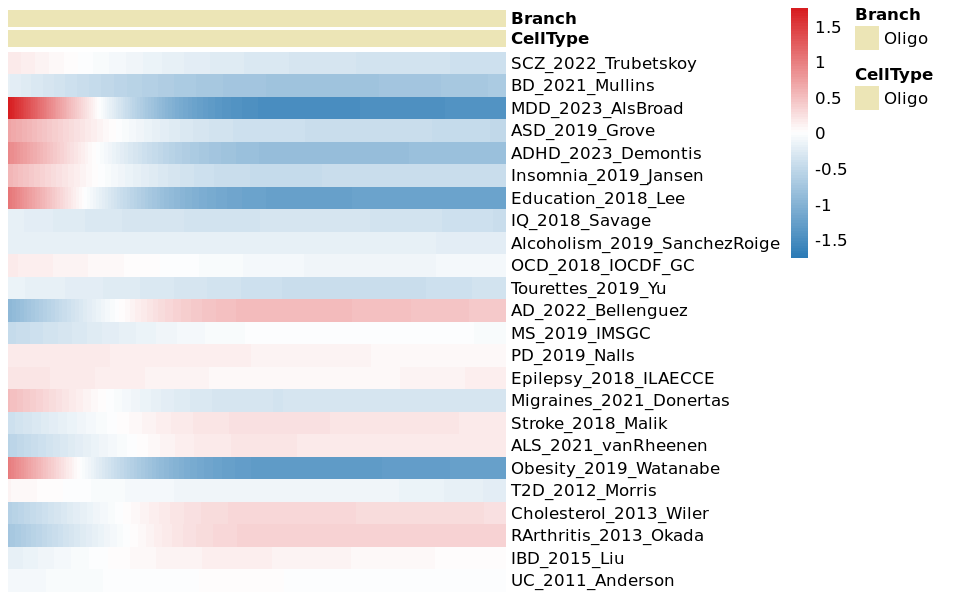

In [25]:
scdrs_fitted_OLIGO <- obtain_fitted_scdrs(cds_OLIGO, "/sc/arion/projects/CommonMind/aging/hui/files/freeze3/scDRS/All_26_consistent_traits_not_removing_covariate/scDRS_zscore_from_python_OLIGO.RDS")
plot_heatmap_fitted_scdrs(scdrs_fitted_OLIGO, 
                          lineages = names(cds_OLIGO@lineages), 
                          branches = rep("Oligo", 500), 
                          n_metacell = 500, 
                          out_file = "/sc/arion//projects/CommonMind/aging/hui/files//freeze3/figures/oligo_scdrs_zscore_heatmap.pdf",
                          figure_width = 5,
                          figure_height = 5,
                          vmin = -max(abs(unlist(scdrs_fitted_OLIGO))), 
                          vmax = max(abs(unlist(scdrs_fitted_OLIGO))))
